In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs
subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

from scipy import interpolate

from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression

def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 0))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X

def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression().fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

print(len(subjects), subjects)
print("average number of runs:", np.mean(list(subjects_runs.values())),
      "+-", np.std(list(subjects_runs.values())))

18 ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']
average number of runs: 7.388888888888889 +- 3.0393509703533175


In [3]:
from mocet import get_motion_params

basis_params = np.load('../../data/simulation/basis_params.npy')
basis_data = pickle.load(open('../../data/simulation/basis_data.pkl', 'rb'))

def get_model_pupil_displacement(subject, session, task, run, scale):
    motion_param_labels = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
    root = f'{project_dir}/data/eyetracking/{subject}/{session}'
    confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

    basis_idx = basis_data[(subject, session, task, run)]

    fmriprep_confounds = pd.read_csv(confounds_fname, delimiter='\t')
    motion_params = fmriprep_confounds[motion_param_labels]
    motion_params = np.nan_to_num(motion_params) * scale
    motion_params = motion_params - motion_params[0, :]

    displacements = mocet.simulation.inplane_displacement(motion_params, basis_params[basis_idx])
    return displacements

def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data

In [4]:


calibration_errors = {}
validation_errors = {}
displacements = {}
correction_types = ['mocet', 'mocet_large', 'mocet_nonlinear', 'polynomial']
scales = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]
for correction_type in correction_types:
    calibration_errors[correction_type] = {}
    validation_errors[correction_type] = {}
    displacements[correction_type] = {}
    for scale in scales:
        calibration_errors[correction_type][scale] = []
        validation_errors[correction_type][scale] = []
        displacements[correction_type][scale] = []

for correction_type in correction_types:
    for scale in scales:
        print(correction_type, scale)
        for subject in subjects:
            sessions = subject_pool[subject].keys()
            for session in sessions:
                runs = subject_pool[subject][session]
                root = f'{project_dir}/data/simulation/{scale}/{subject}/{session}'
                for r in runs:
                    run = f'run-{r}'
                    np.random.seed(0)
                    key = (subject, session, task, run)
                    if key in valid_data.keys():

                        confounds_fname = (f'{project_dir}/data/eyetracking/{subject}/{session}/' +
                                           f'{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv')
                        simulation_fname = f'{root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                        simulation_data = pd.read_csv(simulation_fname)

                        model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                        model_pupil_data[:, 0] = simulation_data['center_x']
                        model_pupil_data[:, 1] = simulation_data['center_y']
                        model_pupil_size[:, 0] = simulation_data['diameter_px']

                        avg_pupil_diameter_mm = 5
                        pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
                        pupil_data_new = np.zeros_like(model_pupil_data)
                        pupil_data_new[:, 0] = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                        pupil_data_new[:, 1] = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])
                        pupil_data_new = pupil_data_new * pupil_diameter_mm_per_px

                        if correction_type == 'mocet':
                            model_pupil_data = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                                 motion_params_fname=confounds_fname,
                                                                 polynomial_order=3,
                                                                 )
                        elif correction_type == 'mocet_large':
                            model_pupil_data = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                                 motion_params_fname=confounds_fname,
                                                                 large_motion_params=True,
                                                                 polynomial_order=3,
                                                                 )
                        elif correction_type == 'mocet_nonlinear':
                            model_pupil_data = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                                 motion_params_fname=confounds_fname,
                                                                 interactions=True,
                                                                 polynomial_order=3,
                                                                 )
                        elif correction_type == 'polynomial':
                            model_pupil_data = polynomial_detrending(pupil_data_new, 3)

                        t_cal = 0
                        t_val = 1

                        offset = calibration_onsets[t_cal]
                        calibration_pupils = []
                        for i in np.arange(calibration_points[t_cal]):
                            start = (offset + i)
                            calibration_pupils.append(
                                [np.nanmean(model_pupil_data[start, 0]), np.nanmean(model_pupil_data[start, 1])])
                        calibration_pupils = np.array(calibration_pupils)

                        repeat = True if calibration_points[t_cal] == 24 else False
                        calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                                  calibration_order=calibration_order,
                                                                  repeat=repeat)
                        calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1], allow_lossy_fit=True)
                        gaze_coordinates = calibrator.transform(model_pupil_data)

                        for t in [t_cal, t_val]:
                            MSE = []
                            offset = calibration_onsets[t]
                            for i in np.arange(calibration_points[t]):
                                ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                                ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                                start = (offset + i)
                                data_x = np.nanmean(gaze_coordinates[start, 0])
                                data_y = np.nanmean(gaze_coordinates[start, 1])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                            if t == t_cal:
                                calibration_error = np.nanmean(MSE) / px_per_deg
                                calibration_errors[correction_type][scale].append(calibration_error)
                            elif t == t_val:
                                validation_error = np.nanmean(MSE) / px_per_deg
                                validation_errors[correction_type][scale].append(validation_error)

                        displacement = get_model_pupil_displacement(subject, session, task, run, scale)
                        displacements[correction_type][scale].append(displacement)

mocet 0.2
mocet 0.4
mocet 0.6
mocet 0.8
mocet 1.0
mocet 1.2
mocet 1.4
mocet 1.6
mocet 1.8
mocet 2.0
mocet 2.2
mocet 2.4
mocet 2.6
mocet 2.8
mocet 3.0
mocet 3.2
mocet 3.4
mocet 3.6
mocet 3.8
mocet 4.0
mocet_large 0.2
mocet_large 0.4
mocet_large 0.6
mocet_large 0.8
mocet_large 1.0
mocet_large 1.2
mocet_large 1.4
mocet_large 1.6
mocet_large 1.8
mocet_large 2.0
mocet_large 2.2
mocet_large 2.4
mocet_large 2.6
mocet_large 2.8
mocet_large 3.0
mocet_large 3.2
mocet_large 3.4
mocet_large 3.6
mocet_large 3.8
mocet_large 4.0
mocet_nonlinear 0.2
mocet_nonlinear 0.4
mocet_nonlinear 0.6
mocet_nonlinear 0.8
mocet_nonlinear 1.0
mocet_nonlinear 1.2
mocet_nonlinear 1.4
mocet_nonlinear 1.6
mocet_nonlinear 1.8
mocet_nonlinear 2.0
mocet_nonlinear 2.2
mocet_nonlinear 2.4
mocet_nonlinear 2.6
mocet_nonlinear 2.8
mocet_nonlinear 3.0
mocet_nonlinear 3.2
mocet_nonlinear 3.4
mocet_nonlinear 3.6
mocet_nonlinear 3.8
mocet_nonlinear 4.0
polynomial 0.2
polynomial 0.4
polynomial 0.6
polynomial 0.8
polynomial 1.0
polyn

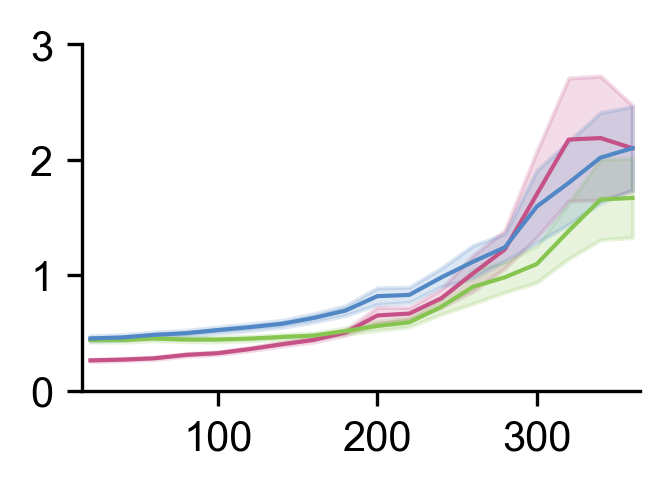

In [12]:
from scipy.stats import sem
plt.style.use('default')
colors = ['#c55187', '#87c551', '#5187c5', '#5e997d']
scales = [0.2, 0.4, 0.6, 0.8, 1.0 , 1.2, 1.4, 1.6, 1.8, 2.0 , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]

fig, ax = plt.subplots(1,1,figsize=(2.4,1.5), dpi=300)
for c,  correction_type in enumerate(correction_types[:3]):
    means = []
    errors = []
    for scale in scales:
        mean = np.mean(validation_errors[correction_type][scale])
        error = sem(validation_errors[correction_type][scale])
        means.append(mean)
        errors.append(error)
    means = np.array(means)
    errors = np.array(errors)
    ax.plot(scales, means, color=colors[c], lw=1)
    ax.fill_between(scales, means - errors, means + errors, color=colors[c], alpha=0.2)
ax.set_xticks([1.0,2.0,3.0])
ax.set_xlim(0.2-0.05, 3.6+0.05)
ax.set_yticks([0.0, 1.0, 2.0, 3.0])
ax.set_xticklabels([f'{int(scale*100)}' for scale in [1.0, 2.0, 3.0] ])

#ax.axvline(x=1.0, c='k', lw=0.8, linestyle=':')
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")

In [11]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection

p_values = []
for scale in scales:
    t, p = ttest_rel(validation_errors['mocet'][scale],
                     validation_errors['mocet_large'][scale])
    sig = '*' if p < 0.05 else ''
    print(scale, t, p, sig)
    p_values.append(p)
rejected, corrected_p = fdrcorrection(p_values, alpha=0.05)
print(rejected)
print(corrected_p)

0.2 -11.063127079530881 1.5518153296232295e-20 *
0.4 -10.723073339672155 1.1089269191055424e-19 *
0.6 -10.664767791264367 1.5531787954641943e-19 *
0.8 -8.797429547221752 6.694655841952676e-15 *
1.0 -7.248478483123693 3.17445386131664e-11 *
1.2 -5.472745162853041 2.1508399580889932e-07 *
1.4 -3.3777170299301837 0.0009608500096025953 *
1.6 -1.932888468789203 0.05539131398932935 
1.8 -0.5860680697915858 0.558830562079454 
2.0 2.1320000671180144 0.03485902837135193 *
2.2 2.4586827757388128 0.01523988946565558 *
2.4 1.5973243897820262 0.1125846017981967 
2.6 2.1611825360672867 0.03248586694838409 *
2.8 4.094582122400041 7.328194466564462e-05 *
3.0 2.474041293091152 0.014628466755553848 *
3.2 2.530664126143982 0.012558942070840495 *
3.4 2.5090426520579787 0.013316067606206022 *
3.6 3.1957357829169664 0.001745159108316618 *
[ True  True  True  True  True  True  True False False  True  True False
  True  True  True  True  True  True]
[2.79326759e-19 9.31907277e-19 9.31907277e-19 3.01259513e-14